In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data=np.load("../data/training_data/BlackScholes-77/data.npy")

In [3]:
data.shape

(10000, 1, 101)

In [31]:
gen_data=np.load("../data/generated_data/data_bs.npy")

In [32]:
gen_data.shape

(1000, 1, 101)

In [33]:
real_data = torch.tensor(data[:1000, 0, :])
fake_data = torch.tensor(gen_data[:, 0, :])

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# Compare (visualize) paths
def compare_path(x_real, x_fake, titles=["Real", "Fake"], file_path=None, return_figax=False, dim=0, plot_size=100):
    fig, ax = plt.subplots(1, 2, figsize=[12, 4], sharex=True, sharey=True)
    ax[0].plot(
        x_real[:plot_size].numpy().T,
        alpha=0.3,
        marker="o",
        linewidth=1,
        markersize=1,
    )
    
    ax[1].plot(
        x_fake[:plot_size].numpy().T,
        alpha=0.3,
        marker="o",
        linewidth=1,
        markersize=1,
    )
    
    if titles:
        ax[0].set_title(titles[0])
        ax[1].set_title(titles[1])

    for i in range(2):
        ax[i].set_xlabel("Time")
        ax[i].set_ylabel("Prices")
    if return_figax:
        return fig, ax
    if file_path is None:
        plt.show()
    else:
        plt.savefig(file_path, bbox_inches="tight")
    plt.close()

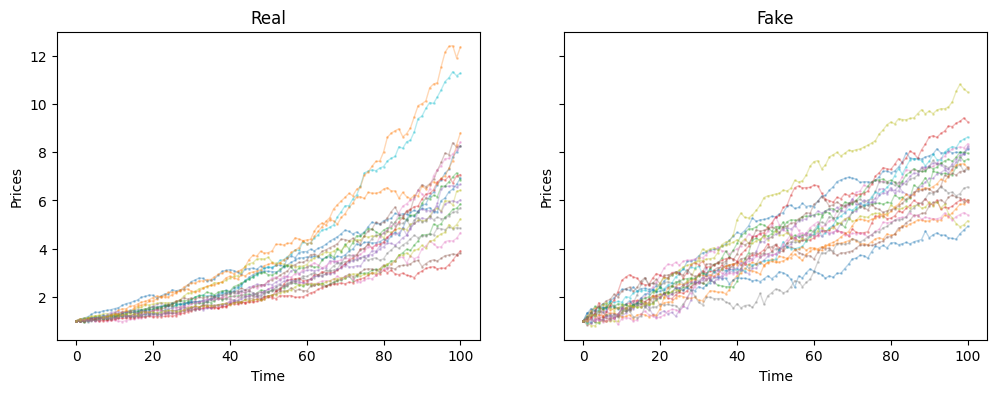

In [73]:
compare_path(real_data,fake_data, plot_size=19)

In [22]:
# Compare Marginal
def compare_marginal_hist(real_data, fake_data, n_time_slice=4, file_path=None):
    time_range = np.linspace(11, real_data.shape[1] - 1, n_time_slice, dtype=int)
    n_cols = n_time_slice
    fig, ax = plt.subplots(1, n_cols, figsize=[12, 4], sharey=True, sharex=True)
    bins = np.linspace(0, 5, 50)
    for i in range(n_cols):
        axi = ax.flat[i]
        n = time_range[i]
        axi.hist(real_data[:, n], bins=bins, alpha=0.5, label="real")
        axi.hist(fake_data[:, n], bins=bins, alpha=0.3, label="fake")
        axi.set_title(f"Time: {n}")
        axi.legend()
        # axi.set_xlabel("Marginal prices")
    if file_path is None:
        plt.show()
    else:
        plt.savefig(file_path, bbox_inches="tight")
        plt.close(fig)

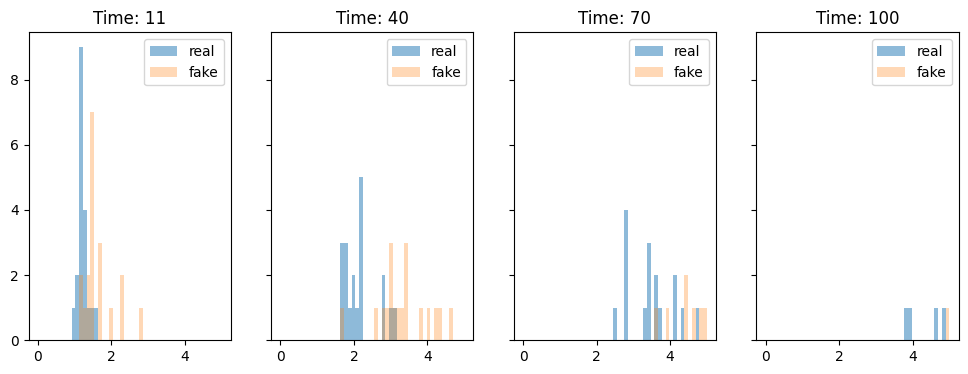

In [72]:
compare_marginal_hist(real_data[:19,], fake_data[:19,], 4)

In [24]:
# Compare Drift and Volatility
def prices2returns(prices):
    returns = prices[:, 1:] / prices[:, :-1] - 1
    return returns


def compute_volatility(price_path, T):
    return_path = prices2returns(price_path)
    vol2 = torch.sum(return_path**2, dim=1) / T
    vol = torch.sqrt(vol2)
    return vol


def compute_drift(price_path, T):
    return_path = prices2returns(price_path)
    drift = torch.sum(return_path, dim=1) / T
    return drift


def plot_mean_log_prices(data, data_name, axi):
    data = torch.log(data)
    data_mean = torch.mean(data, dim=0)
    data_std = torch.std(data, dim=0)
    axi.plot(data_mean, marker="o", linewidth=1, markersize=1, label=data_name)
    axi.fill_between(
        torch.arange(len(data_mean)),
        data_mean - data_std,
        data_mean + data_std,
        alpha=0.2,
    )


def compare_drift_volatility(real_data, fake_data, T):
    fig, ax = plt.subplots(1, 2, figsize=[12, 4])

    plot_mean_log_prices(real_data, "real", ax[0])
    plot_mean_log_prices(fake_data, "fake", ax[0])
    ax[0].legend()
    ax[0].set_xlabel("Time")
    ax[0].set_title("Log-prices")

    vol = compute_volatility(real_data, T)
    ax[1].hist(vol, bins=100, alpha=0.4, label="real", density=True)
    # sns.kdeplot(vol,ax = ax[1])
    vol = compute_volatility(fake_data, T)
    ax[1].hist(vol, bins=100, alpha=0.4, label="fake", density=True)
    # sns.kdeplot(vol,ax = ax[1])
    ax[1].legend()
    ax[1].set_title("Volatility")
    ax[1].set_xlabel("Volatility")
    plt.show()

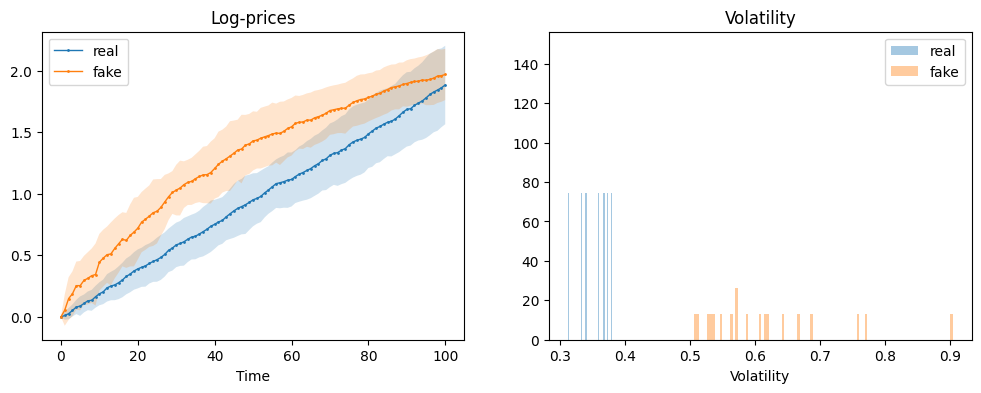

In [71]:
compare_drift_volatility(real_data[:19,:],fake_data[:19,:],1)

In [75]:
def estimate_params(X, dt=0.01):
    #log_rets=np.log(X[:,1:]/X[:,:-1])
    log_rets=X[:,1:]/X[:,:-1]-1
    r=log_rets.ravel()
    
    m=np.mean(r)
    s=np.std(r,ddof=1)
    
    sigma=s/np.sqrt(dt)
    mu=(m/dt)+0.5*sigma**2
    
    return mu, sigma
    #return m, s 

In [80]:
estimate_params(gen_data[:19,0,:])

(2.326253377686527, 0.587228536605835)

In [62]:
import numpy as np
from scipy.optimize import curve_fit

def detrend_log_linear(prices):
    log_prices = np.log(prices)
    n_paths, n_steps = log_prices.shape
    t = np.arange(n_steps)

    detrended = np.zeros_like(log_prices)

    def exponential_func(t, a, b):
        return a * np.exp(b * t)
    
    for i in range(n_paths):
        params, _ = curve_fit(exponential_func, t, prices[i], maxfev=10000)
        a, b = params
    
        trend = exponential_func(t, a, b)
        detrended[i] = prices[i] - trend
    
    return detrended

In [69]:
estimate_params(detrend_log_linear(data[:19,0,:]))

(1.1554108592627723, 0.781316494250588)

In [70]:
estimate_params(detrend_log_linear(gen_data[:19,0,:]))

(1.1532553, 0.77734387)